In [1]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0.学习任务：

完成我们的简化目标检测网络Tiny_Detector的训练

对训练好的网络进行评测

训练过程中，多读读代码，强化记忆本章介绍的内容

如果你有精力，不妨思考下如何改进下网络，并动手实践。

- 学习资料

  - [3.6、训练与测试](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_6)


# 1.模型训练

目标检测网络的训练大致是如下的流程：

- 设置各种超参数
- 定义数据加载模块 dataloader
- 定义网络 model
- 定义损失函数 loss
- 定义优化器 optimizer
- 遍历训练数据，预测-计算loss-反向传播


In [ ]:
import time                                                                                                                                    
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import tiny_detector, MultiBoxLoss
from datasets import PascalVOCDataset
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

# Data parameters
data_folder = '../../../dataset/VOCdevkit'  # data files root path
keep_difficult = True  # use objects considered difficult to detect?
n_classes = len(label_map)  # number of different types of objects

# Learning parameters
total_epochs = 230 # number of epochs to train
batch_size = 32  # batch size
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 100  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [150, 190]  # decay learning rate after these many epochs
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay


In [ ]:
def main():
    """
    Training.
    """
    # Initialize model and optimizer
    model = tiny_detector(n_classes=n_classes)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy)
    optimizer = torch.optim.SGD(params=model.parameters(),
                                lr=lr, 
                                momentum=momentum,
                                weight_decay=weight_decay)

    # Move to default device
    model = model.to(device)
    criterion = criterion.to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset,   
                                    batch_size=batch_size,
                                    shuffle=True,
                                    collate_fn=train_dataset.collate_fn, 
                                    num_workers=workers,
                                    pin_memory=True) 

    # Epochs
    for epoch in range(total_epochs):
        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training                                                                                                                 
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)


执行 `python train.py ` 等待训练完成

# 2.后处理

## 2.1.目标框信息解码


之前我们的提到过，模型不是直接预测的目标框信息，而是预测的基于anchor的偏移，且经过了编码。因此后处理的第一步，就是对模型的回归头的输出进行解码，拿到真正意义上的目标框的预测结果。

后处理还需要做什么呢？由于我们预设了大量的先验框，因此预测时在目标周围会形成大量高度重合的检测框，而我们目标检测的结果只希望保留一个足够准确的预测框，所以就需要使用某些算法对检测框去重。这个去重算法叫做NMS，下面我们详细来讲一讲。


## 2.2.NMS非极大值抑制

NMS的大致算法步骤如下：

按照类别分组，依次遍历每个类别。

当前类别按分类置信度排序，并且设置一个最低置信度阈值如0.05，低于这个阈值的目标框直接舍弃。

当前概率最高的框作为候选框，其它所有与候选框的IOU高于一个阈值（自己设定，如0.5）的框认为需要被抑制，从剩余框数组中删除。

然后在剩余的框里寻找概率第二大的框，其它所有与第二大的框的IOU高于设定阈值的框被抑制。

依次类推重复这个过程，直至遍历完所有剩余框，所有没被抑制的框即为最终检测框。

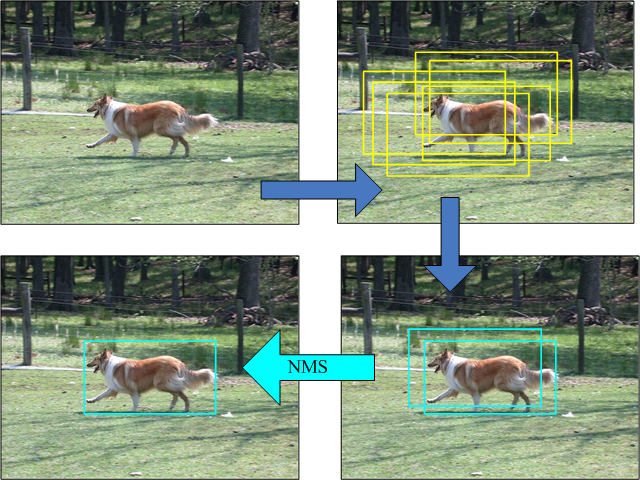

## 2.3.代码实现:

In [ ]:
def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
    """                                                                                                                                                       
    Decipher the 441 locations and class scores (output of the tiny_detector) to detect objects.

    For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

    :param predicted_locs: predicted locations/boxes w.r.t the 441 prior boxes, a tensor of dimensions (N, 441, 4)
    :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 441, n_classes)
    :param min_score: minimum threshold for a box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :return: detections (boxes, labels, and scores), lists of length batch_size
    """
    batch_size = predicted_locs.size(0)
    n_priors = self.priors_cxcy.size(0)
    predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 441, n_classes)

    # Lists to store final predicted boxes, labels, and scores for all images in batch
    all_images_boxes = list()
    all_images_labels = list()
    all_images_scores = list()

    assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

    for i in range(batch_size):
        # Decode object coordinates from the form we regressed predicted boxes to
        decoded_locs = cxcy_to_xy(                                                                                                                            
            gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (441, 4), these are fractional pt. coordinates

        # Lists to store boxes and scores for this image
        image_boxes = list()
        image_labels = list()
        image_scores = list()

        max_scores, best_label = predicted_scores[i].max(dim=1)  # (441)

        # Check for each class
        for c in range(1, self.n_classes):
            # Keep only predicted boxes and scores where scores for this class are above the minimum score
            class_scores = predicted_scores[i][:, c]  # (441)
            score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
            n_above_min_score = score_above_min_score.sum().item()
            if n_above_min_score == 0:
                continue
            class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 441
            class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

            # Sort predicted boxes and scores by scores
            class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
            class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

            # Find the overlap between predicted boxes
            overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

            # Non-Maximum Suppression (NMS)

            # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
            # 1 implies suppress, 0 implies don't suppress
            suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

            # Consider each box in order of decreasing scores
            for box in range(class_decoded_locs.size(0)):
                # If this box is already marked for suppression
                if suppress[box] == 1:
                    continue

                # Suppress boxes whose overlaps (with current box) are greater than maximum overlap
                # Find such boxes and update suppress indices
                suppress = torch.max(suppress, (overlap[box] > max_overlap).to(torch.uint8))
                # The max operation retains previously suppressed boxes, like an 'OR' operation

                # Don't suppress this box, even though it has an overlap of 1 with itself
                suppress[box] = 0

            # Store only unsuppressed boxes for this class
            image_boxes.append(class_decoded_locs[1 - suppress])
            image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
            image_scores.append(class_scores[1 - suppress])

        # If no object in any class is found, store a placeholder for 'background'
        if len(image_boxes) == 0:
            image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
            image_labels.append(torch.LongTensor([0]).to(device))
            image_scores.append(torch.FloatTensor([0.]).to(device))

        # Concatenate into single tensors
        image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
        image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
        image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
        n_objects = image_scores.size(0)

        # Keep only the top k objects
        if n_objects > top_k:
            image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
            image_scores = image_scores[:top_k]  # (top_k)
            image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
            image_labels = image_labels[sort_ind][:top_k]  # (top_k)

        # Append to lists that store predicted boxes and scores for all images
        all_images_boxes.append(image_boxes)
        all_images_labels.append(image_labels)
        all_images_scores.append(image_scores)

    return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size


可以参照Fast R-CNN的后处理代码进行理解

In [ ]:
# --------------------------------------------------------
# Fast R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------
import numpy as np
# dets: 检测的 boxes 及对应的 scores；
# thresh: 设定的阈值

def nms(dets,thresh):
    # boxes 位置
    x1 = dets[:,0] 
    y1 = dets[:,1] 
    x2 = dets[:,2]
    y2 = dets[:,3]
    # boxes scores
    scores = dets[:,4]
    areas = (x2-x1+1)*(y2-y1+1)   # 各box的面积
    order = scores.argsort()[::-1]  # 分类置信度排序
    keep = []                        # 记录保留下的 boxes
    while order.size > 0:
        i = order[0]               # score最大的box对应的 index
        keep.append(i)        # 将本轮score最大的box的index保留
        \# 计算剩余 boxes 与当前 box 的重叠程度 IoU
        xx1 = np.maximum(x1[i],x1[order[1:]])
        yy1 = np.maximum(y1[i],y1[order[1:]])
        xx2 = np.minimum(x2[i],x2[order[1:]])
        yy2 = np.minimum(y2[i],y2[order[1:]])
        w = np.maximum(0.0,xx2-xx1+1) # IoU
        h = np.maximum(0.0,yy2-yy1+1)
        inter = w*h
        ovr = inter/(areas[i]+areas[order[1:]]-inter)
        \# 保留 IoU 小于设定阈值的 boxes
        inds = np.where(ovr<=thresh)[0]
        order = order[inds+1]
    return keep


# 3.单图预测推理
当模型已经训练完成后，下面我们来看下如何对单张图片进行推理，得到目标检测结果。

首先我们需要导入必要的python包，然后加载训练好的模型权重。

随后我们需要定义预处理函数。为了达到最好的预测效果，测试环节的预处理方案需要和训练时保持一致，仅去除掉数据增强相关的变换即可。

因此，这里我们需要进行的预处理为：

- 将图片缩放为 224 * 224 的大小
- 转换为 Tensor 并除 255
- 进行减均值除方差的归一化


In [ ]:
# Set detect transforms (It's important to be consistent with training)
resize = transforms.Resize((224, 224))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

接着我们就来进行推理，过程很简单，核心流程可以概括为：

- 读取一张图片
- 预处理
- 模型预测
- 对模型预测进行后处理

In [ ]:
# Transform the image
image = normalize(to_tensor(resize(original_image)))

# Move to default device
image = image.to(device)

# Forward prop.
predicted_locs, predicted_scores = model(image.unsqueeze(0))

# Post process, get the final detect objects from our tiny detector output
det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score, max_overlap=max_overlap, top_k=top_k)


这里的detect_objects 函数完成模型预测结果的后处理，主要工作有两个，首先对模型的输出进行解码，得到代表具体位置信息的预测框，随后对所有预测框按类别进行NMS，来过滤掉一些多余的检测框，也就是我们上一小节介绍的内容。

最后，我们将最终得到的检测框结果进行绘制，得到类似如下图的检测结果：

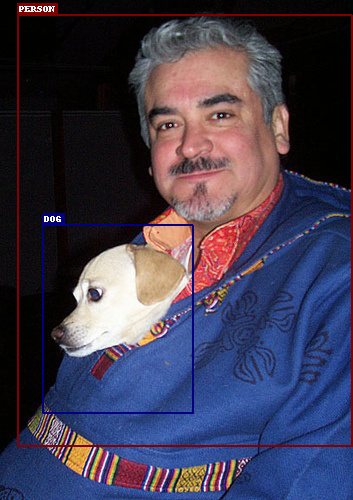

# 4.VOC测试集评测

## 4.1.介绍map指标
以分类模型中最简单的二分类为例，对于这种问题，我们的模型最终需要判断样本的结果是0还是1，或者说是positive还是negative。我们通过样本的采集，能够直接知道真实情况下，哪些数据结果是positive，哪些结果是negative。同时，我们通过用样本数据跑出分类模型的结果，也可以知道模型认为这些数据哪些是positive，哪些是negative。因此，我们就能得到这样四个基础指标，称他们是一级指标（最底层的）：

1）真实值是positive，模型认为是positive的数量（True Positive=TP）

2）真实值是positive，模型认为是negative的数量（False Negative = FN）：这就是统计学上的第二类错误（Type II Error）

3）真实值是negative，模型认为是positive的数量（False Positive = FP）：这就是统计学上的第一类错误（Type I Error）

4）真实值是negative，模型认为是negative的数量（True Negative = TN）


在机器学习领域，混淆矩阵（confusion matrix），又称为可能性表格或错误矩阵。它是一种特定的矩阵用来呈现算法性能的可视化效果，通常用于监督学习（非监督学习，通常用匹配矩阵：matching matrix）。其每一列代表预测值，每一行代表的是实际的类别。这个名字来源于它可以非常容易的表明多个类别是否有混淆（也就是一个class被预测成另一个class）。



二级指标：混淆矩阵里面统计的是个数，有时候面对大量的数据，光凭算个数，很难衡量模型的优劣。因此混淆矩阵在基本的统计结果上又延伸了如下4个指标，我称他们是二级指标（通过最底层指标加减乘除得到的）：

1）准确率（Accuracy）-----针对整个模型

2）精确率（Precision）

3）灵敏度（Sensitivity）：就是召回率（Recall）

4）特异度（Specificity）

用表格的方式将这四种指标的定义、计算、理解进行汇总：

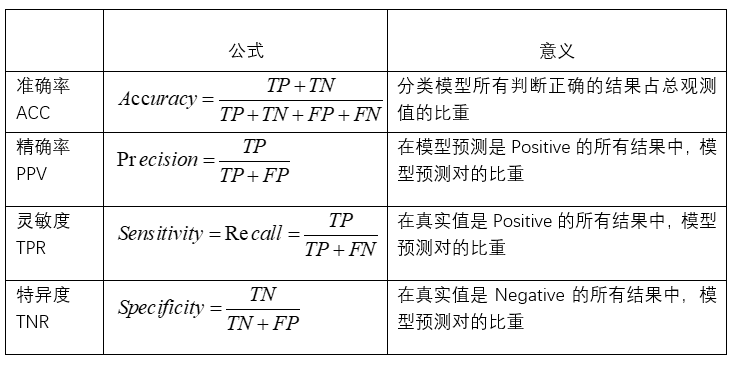

通过上面的四个二级指标，可以将混淆矩阵中数量的结果转化为0-1之间的比率。便于进行标准化的衡量。

三级指标：这个指标叫做F1 Score。他的计算公式是：

F1 Score = 2PR / P+R

其中，P代表Precision，R代表Recall（召回率）。F1-Score指标综合了Precision与Recall的产出的结果。F1-Score的取值范围从0到1,1代表模型的输出最好，0代表模型的输出结果最差。

AP指标即Average Precision 即平均精确度。

mAP即Mean Average Precision即平均AP值，是对多个验证集个体求平均AP值，作为object detection中衡量检测精度的指标。

在目标检测场景如何计算AP呢，这里需要引出P-R曲线，即以precision和recall作为纵、横轴坐标的二维曲线。通过选取不同阈值时对应的精度和召回率画出，如下图所示：

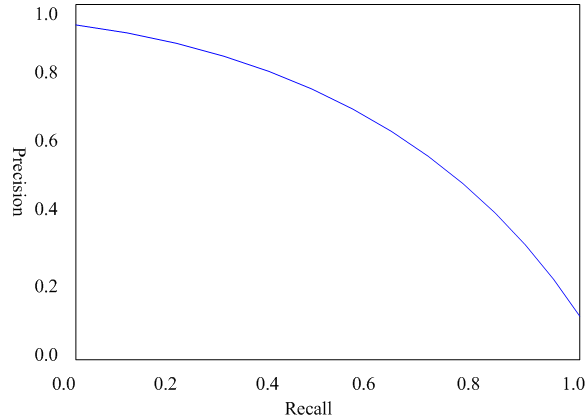

P-R曲线的总体趋势是，精度越高，召回越低，当召回到达1时，对应概率分数最低的正样本，这个时候正样本数量除以所有大于等于该阈值的样本数量就是最低的精度值。 另外，P-R曲线围起来的面积就是AP值，通常来说一个越好的分类器，AP值越高。

总结：在目标检测中，每一类都可以根据recall和precision绘制P-R曲线，AP就是该曲线下的面积，mAP就是所有类的AP的平均值。(这里说的是VOC数据集的mAP指标的计算方法，COCO数据集的计算方法略有差异）



## 4.2.Tiny-Detection VOC测试集评测

运行 `eval.py` 脚本，评估模型在VOC2007测试集上的效果，结果如下：



~~~
$ python eval.py
...
...
Evaluating: 100%|███████████████████████████████| 78/78 [00:57<00:00,  1.35it/s]
{'aeroplane': 0.6086561679840088,
 'bicycle': 0.7144593596458435,
 'bird': 0.5847545862197876,
 'boat': 0.44902321696281433,
 'bottle': 0.2160634696483612,
 'bus': 0.7212041616439819,
 'car': 0.629608154296875,
 'cat': 0.8124480843544006,
 'chair': 0.3599272668361664,
 'cow': 0.5980824828147888,
 'diningtable': 0.6459739804267883,
 'dog': 0.7577021718025208,
 'horse': 0.7861635088920593,
 'motorbike': 0.702280580997467,
 'person': 0.5821948051452637,
 'pottedplant': 0.2793791592121124,
 'sheep': 0.5655995607376099,
 'sofa': 0.708049476146698,
 'train': 0.7575671672821045,
 'tvmonitor': 0.5641061663627625}

Mean Average Precision (mAP): 0.602

~~~

可以看到，模型的mAP得分为60.2，比经典的YOLO网络的63.4的得分稍低，得分还是说的过去的～

同时，我们也可以观察到，某几个类别，例如`bottle`和`pottedplant`的检测效果是很差的，说明我们的模型对于小物体，较为密集的物体的检测是存在明显问题的。

# 总结

这次的组队学习暂时告一段落了，也许到了很多知识，以前最多只是个掉包侠，现在至少能理解一些底层的推导逻辑了，还要继续学习呀，加油，打工人！